In [3]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
bits = Circuit().i(0).x(1)  # create 2-qubit quantum circuit with I gate on qubit 0 and X gate on qubit 1
print(bits)

T  : |0|
        
q0 : -I-
        
q1 : -X-

T  : |0|


Counter({'01': 1000})


Text(0, 0.5, 'counts')

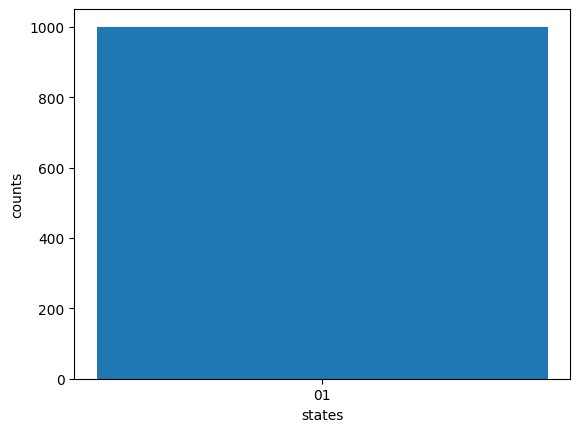

In [5]:
device = LocalSimulator()
result = device.run(bits, shots=1000).result()
counts = result.measurement_counts
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('states')
plt.ylabel('counts')

# Convert decimal to quantum state representing the binary value

In [9]:
def build_binary_circuit(decimal_number):
    binary_num=bin(decimal_number)[2:]
    num_qubits=len(binary_num)
    print(binary_num)
    binary_circuit=Circuit()
    position=0
    for bit in binary_num:
        if bit=='0':
            binary_circuit.i(position)
        else:
            binary_circuit.x(position)
        position+=1
    return(binary_circuit)
    

### Run on local simulator

110
T  : |0|
        
q0 : -X-
        
q1 : -X-
        
q2 : -I-

T  : |0|
Counter({'110': 1000})


Text(0, 0.5, 'counts')

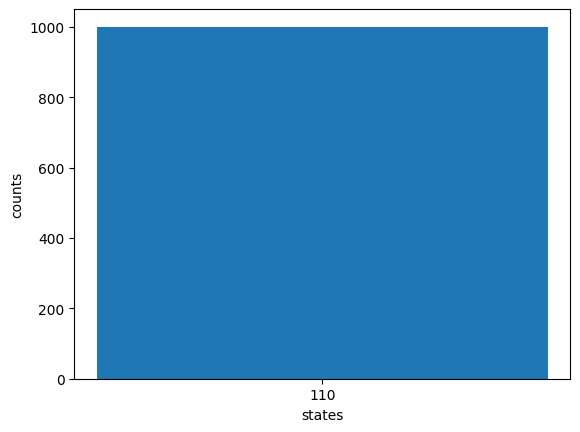

In [13]:
binary_circuit=build_binary_circuit(6)
print(binary_circuit)

device = LocalSimulator()
result = device.run(binary_circuit, shots=1000).result()
counts = result.measurement_counts
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('states')
plt.ylabel('counts')

### Run on Amazon Braket simulator

In [34]:
my_bucket = "amazon-braket-hamacher-useast1"
my_prefix = "/"
s3_folder = (my_bucket, my_prefix)

def run_circuit(device, circuit, shots, s3_folder):
    result = device.run(binary_circuit, shots=shots, s3_destination_folder=s3_folder).result()
    counts = result.measurement_counts
    print(counts)
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('states')
    plt.ylabel('counts')
    return(result)

def actual_simulator_cost(device, result):
    price_per_min = device.properties.service.deviceCost.price
    price_per_ms = price_per_min/60/1000
    unit = device.properties.service.deviceCost.unit
    duration_ms = result.additional_metadata.simulatorMetadata.executionDuration
    if unit == 'minute':
        print('simulator cost per ', unit, ': $', price_per_min)
        print('total execution time: ', duration_ms, "ms")
        print('total estimated cost: $', duration_ms*price_per_ms)

def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', printValidDeviceNames(printAllDevices()))

def estimate_cost(device,num_shots=1000):
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Forte 1','Harmony', 'Aquila', 'Lucy']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', printValidDeviceNames(printAllDevices))

def estimate_cost_measured_qubits(device,measured_qubits):
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)   

In [30]:
N=2896
qubit_count=len(bin(N))-2
print('qubit count: ', qubit_count)
binary_circuit=build_binary_circuit(N)
print(binary_circuit)

qubit count:  12
101101010000
T   : |0|
         
q0  : -X-
         
q1  : -I-
         
q2  : -X-
         
q3  : -X-
         
q4  : -I-
         
q5  : -X-
         
q6  : -I-
         
q7  : -X-
         
q8  : -I-
         
q9  : -I-
         
q10 : -I-
         
q11 : -I-

T   : |0|


In [31]:
device=set_device('SV1')
estimate_cost_measured_qubits(device, qubit_count)

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
max shots: 100000
for 12 measured qubits the maximum allowed shots: 100,000
simulator cost per  minute : $ 0.075
total cost cannot be estimated


Counter({'101101010000': 10})


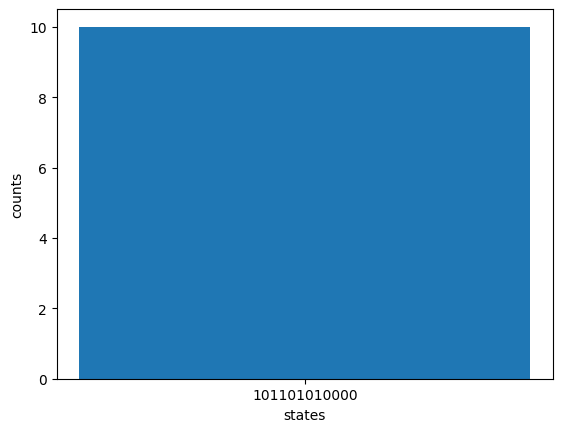

In [32]:
result=run_circuit(device, binary_circuit, 10, s3_folder)

In [35]:
actual_simulator_cost(device, result)

simulator cost per  minute : $ 0.075
total execution time:  2 ms
total estimated cost: $ 2.5e-06
